# Drug discovery using ChEMBL

ChEMBL or ChEMBLdb is a manually curated chemical database of bioactive molecules with drug-like properties. It is maintained by the European Bioinformatics Institute (EBI), of the European Molecular Biology Laboratory (EMBL), based at the Wellcome Trust Genome Campus, Hinxton, UK. 

#### Table of contents
1.   [Acquire & preprocess molecular data](#acquire)
2.   [Decision tree to predict IC50](#tree)
3.   [TensorFlow](#tensorflow)

## Install dependencies

In [ ]:
%%bash
pip install target-discovery
pip install chembl_webresource_client
pip install padelpy
pip install rdkit-pypi

In [ ]:
from target_discovery import PreprocessChembl, ModelChembl

<a name='acquire'></a>
## Acquire & preprocess molecular data

In [ ]:
pre = PreprocessChembl() #declare class instance
targets = pre.search_chembl('falciparum D6') #search database for a protein
targets.head()

,organism,pref_name,score,target_chembl_id,target_type
0,Plasmodium falciparum D6,Plasmodium falciparum D6,28.0,CHEMBL2367107,ORGANISM
1,Homo sapiens,Atypical chemokine receptor 2,21.0,CHEMBL4105988,SINGLE PROTEIN
2,Plasmodium falciparum,Plasmodium falciparum,15.0,CHEMBL364,ORGANISM
3,Measles virus genotype D6,Measles virus genotype D6,13.0,CHEMBL612932,ORGANISM
4,Plasmodium falciparum 3D7,Plasmodium falciparum 3D7,13.0,CHEMBL2366922,ORGANISM


In [ ]:
target_id = 'CHEMBL2367107' #ID for P. falciparum D6
df = pre.preprocess_target_data(target_id, fingerprints=True) #optional 'fp' param to specify fingerprinter

Query results retrieved for CHEMBL2367107
Found 417 molecules
Computing fingerprints (takes several minutes if molecule count above 1000)...
Success!


In [ ]:
df

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL462797,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL462797,CCC/C=C/c1cc2c(C=O)c(O)c(CC=C(C)C)cc2o1,3.000,active,298.382,5.2729,1.0,3.0,8.52288
1,CHEMBL76,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,0.016,active,319.880,4.8106,1.0,3.0,10.79588
2,CHEMBL76,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,400.000,active,319.880,4.8106,1.0,3.0,6.39794
3,CHEMBL76,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,80.000,active,319.880,4.8106,1.0,3.0,7.09691
4,CHEMBL76,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,0.014,active,319.880,4.8106,1.0,3.0,10.85387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,CHEMBL3116046,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL3116046,Clc1ccc2c(NCCCNc3ccnc(N4CCOCC4)n3)ccnc2c1,50.000,active,398.898,3.4289,2.0,7.0,7.30103
627,CHEMBL3819340,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL3819340,CCN1CCN(c2nc(Cl)cc(NCCNc3ccnc4cc(Cl)ccc34)n2)CC1,50.000,active,446.386,3.9975,2.0,7.0,7.30103
628,CHEMBL3116047,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL3116047,Clc1ccc2c(NCCCNc3ccnc(N4CCCCC4)n3)ccnc2c1,50.000,active,396.926,4.5826,2.0,6.0,7.30103
629,CHEMBL3818968,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CHEMBL3818968,CN1CCN(c2nccc(NCCCNc3ccnc4cc(Cl)ccc34)n2)CC1,50.000,active,411.941,3.3441,2.0,7.0,7.30103


In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

SMILES: Cc1cc(N2CCCCC2)nc(NCCCNc2ccnc3cc(Cl)ccc23)n1


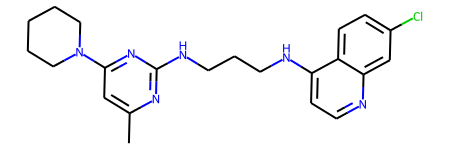

In [ ]:
mol = df.Name[np.random.randint(len(df))]
SMILES = df.canonical_smiles[df.Name==mol].values[0]
print('SMILES:', SMILES)
Chem.MolFromSmiles(SMILES) 

<a name='tree'></a>
## Decision tree regressor to predict IC50

In [ ]:
from sklearn.tree import export_text

In [ ]:
mdl = ModelChembl(test_size=.2, var_threshold=.15) #declare class instance

We've dropped features with low variance (under 0.1) thereby reducing the fingerprint from 881 to 100-200 features. Optionally, try to maximize the cross-validation score in order to find the best hyperparameters.

(504, 83) (504,) (127, 83) (127,)
Cross-validation scores: [0.162 0.481 0.458 0.548 0.295]
Cross-validation average: 0.389
Out-of-sample metrics:
  Mean absolute error: 0.65076
  R-squared: 0.54238


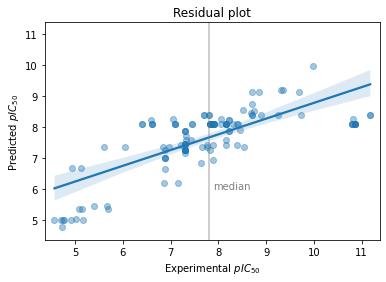

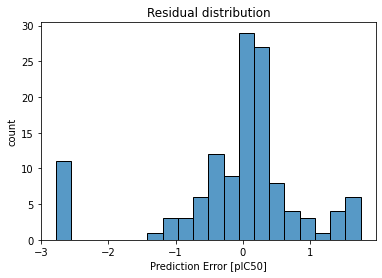

In [ ]:
tree = mdl.decision_tree(df, ccp_alpha=.001)

In [ ]:
print(export_text(tree, max_depth=3))

|--- feature_46 <= 0.50
|   |--- feature_26 <= 0.50
|   |   |--- feature_3 <= 0.50
|   |   |   |--- feature_75 <= 0.50
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- feature_75 >  0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- feature_3 >  0.50
|   |   |   |--- feature_33 <= 0.50
|   |   |   |   |--- value: [5.17]
|   |   |   |--- feature_33 >  0.50
|   |   |   |   |--- truncated branch of depth 3
|   |--- feature_26 >  0.50
|   |   |--- feature_74 <= 0.50
|   |   |   |--- feature_41 <= 0.50
|   |   |   |   |--- value: [10.34]
|   |   |   |--- feature_41 >  0.50
|   |   |   |   |--- truncated branch of depth 6
|   |   |--- feature_74 >  0.50
|   |   |   |--- feature_31 <= 0.50
|   |   |   |   |--- value: [8.00]
|   |   |   |--- feature_31 >  0.50
|   |   |   |   |--- value: [5.04]
|--- feature_46 >  0.50
|   |--- feature_22 <= 0.50
|   |   |--- feature_75 <= 0.50
|   |   |   |--- feature_8 <= 0.50
|   |   |   |   |--- value: [5.59]
|   |   |   |--

In [ ]:
import pickle
pickle.dump(tree, open('tree.pkl', 'wb')) #Saving model for data dashboard app.

In [ ]:
df.to_csv(target_id+'_preprocessed.csv')

<a name='tensorflow'></a>
## TensorFlow

[Basic regression TensorFlow tutorial](https://www.tensorflow.org/tutorials/keras/regression)

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import pandas as pd
import matplotlib.pyplot as plt

In [57]:
X_train, X_test, y_train, y_test = mdl._prepare_dataframe(df)

(504, 83) (504,) (127, 83) (127,)


In [42]:
normalizer = layers.Normalization(input_shape=[X_train.shape[1],])
normalizer.adapt(X_train) #does nothing to binary column

In [43]:
linear_model = tf.keras.Sequential([normalizer,
                                    layers.Dense(units=1)])
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(X_train, y_train, epochs=50, verbose=0, validation_split = 0.2)

In [45]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [pIC50]')
  plt.legend()
  plt.grid(True)

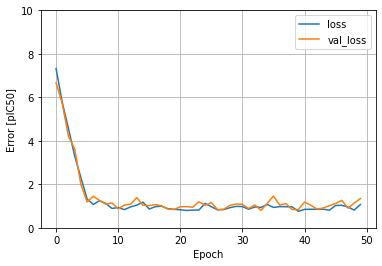

In [48]:
plot_loss(history)


In [49]:
test_results= {}
test_results['linear_model'] = linear_model.evaluate(
    X_test, y_test, verbose=0)

In [50]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'), #kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(64, activation='relu'), #kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [58]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.predict(X_train[:5]) #untrained preds

array([[0.5578197 ],
       [1.1878214 ],
       [0.14451237],
       [1.421957  ],
       [0.5042347 ]], dtype=float32)

In [59]:
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 83)               167       
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                5376      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,768
Trainable params: 9,601
Non-trainable params: 167
_________________________________________________________________


In [60]:
history = dnn_model.fit(X_train, y_train, epochs=50, verbose=0, validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
45,0.497090,0.779807,45
46,0.501563,0.787679,46
47,0.505560,0.759198,47
48,0.495815,0.791884,48
49,0.490026,0.744524,49


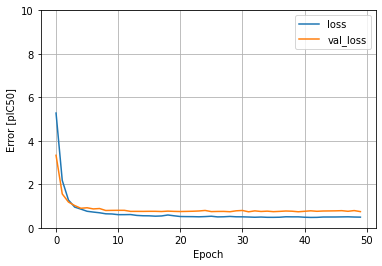

In [61]:
plot_loss(history)


In [68]:
test_results['neural_network'] = dnn_model.evaluate(X_test, y_test, verbose=0)
test_results['decision_tree'] = 0.65076

In [69]:
pd.DataFrame(test_results, index=['Mean absolute error [pIC50]']).T

,Mean absolute error [pIC50]
linear_model,1.251069
neural_network,0.638556
decision_tree,0.650760


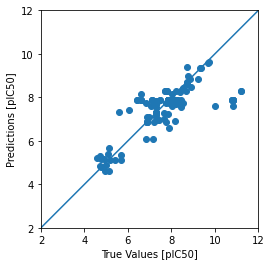

In [64]:
test_predictions = dnn_model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [pIC50]')
plt.ylabel('Predictions [pIC50]')
lims = [2, 12]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


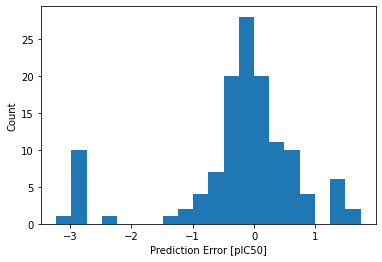

In [65]:
error = test_predictions - y_test
plt.hist(error, bins=20)
plt.xlabel('Prediction Error [pIC50]')
_ = plt.ylabel('Count')

In [66]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [67]:
reloaded = tf.keras.models.load_model('dnn_model')

Mean squared error (MSE) (tf.losses.MeanMeanSquaredError) and mean absolute error (MAE) (tf.losses.MeanAbsoluteError) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.

Similarly, evaluation metrics used for regression differ from classification.

When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.

Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the Overfit and underfit tutorial for more help with this.
